In [446]:
import re

import networkx as nx

from IPython.display import Image, display
from collections import defaultdict, Counter

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.style.use('seaborn-muted')

In [86]:
hash((Matcher.__class__.__name__, 1,'test', 'god'))

434585705789121473

In [88]:
id(Matcher)

140486894794072

In [111]:
class Token:
    
    def __init__(self, token, ignore_case=True, scrub_re='\.'):
        
        self.ignore_case = ignore_case
        self.scrub_re = scrub_re
        
        self.token = token
        self.token_clean = self._clean(token)
        
    def _clean(self, token):
        
        if self.ignore_case:
            token = token.lower()
            
        if self.scrub_re:
            token = re.sub(self.scrub_re, '', token)
            
        return token
    
    def __call__(self, input_token):
        return self._clean(input_token) == self.token_clean
    
    def __repr__(self):
        return '%s<%s>' % (self.__class__.__name__, self.token_clean)
    
    def __str__(self):
        return '<%s>' % self.token_clean
    
    def __hash__(self):
        return hash((id(self.__class__), self.token_clean, self.ignore_case, self.scrub_re))
    
    def __eq__(self, other):
        return hash(self) == hash(other)

In [115]:
t1 = Token('SOUTH')
t2 = Token('south')

In [116]:
t1==t2

True

In [117]:
{t1: 1, t2: 2}

{Token<south>: 2}

In [131]:
class GeoFSA(nx.DiGraph):
    
    def __init__(self):
        super().__init__()
        self.start_node = self.next_node()
        
    def next_node(self):
        """Get next integer node id, counting up.
        """
        node = max(self.nodes) + 1 if self.nodes else 0
        self.add_node(node)
        return node
        
    def add_token(self, accept_fn, parent=None, optional=False):
        
        s1 = parent if parent else self.start_node
        
        s2 = None
        for d, attrs in self[s1].items():
            if attrs.get('accept_fn') == accept_fn:
                s2 = d
                break
                
        if not s2:
            s2 = self.next_node()
        
        self.add_edge(s1, s2, accept_fn=accept_fn, label=str(accept_fn))
        
        last_node = s2
        
        # Add skip transition if optional.
        if optional:
            s3 = self.next_node()
            self.add_edge(s2, s3, label='ε')
            self.add_edge(s1, s3, label='ε')
            last_node = s3
        
        return last_node

In [132]:
class Matcher:
    
    def __init__(self, fsa):
        self.fsa = fsa
        self._states = set([0])
        self.accepted = []
        
    def step(self, start_state, token, visited=None):
        
        if not visited:
            visited = set()
            
        visited.add(start_state)
        
        next_states = set()
        for d_state, attrs in self.fsa[start_state].items():
            
            accept_fn = attrs.get('accept_fn')
            
            if accept_fn:
                if accept_fn(token):
                    next_states.add(d_state)
                    
            elif d_state not in visited: 
                next_states.update(self.step(d_state, token, visited))
                
        return next_states
        
    def __call__(self, token):
        
        next_states = set()
        for state in self._states:
            next_states.update(self.step(state, token))
            
        if next_states:
            self._states = next_states
            self.accepted.append(token)
            return True
        
        return False

In [517]:
g = GeoFSA()

south = g.add_token(Token('South'))
lake = g.add_token(Token('Lake'), south)
tahoe = g.add_token(Token('Tahoe'), lake)
comma = g.add_token(Token(','), tahoe, optional=True)
ca = g.add_token(Token('CA'), comma)
california = g.add_token(Token('California'), comma)

los = g.add_token(Token('Los'))
angeles = g.add_token(Token('Angeles'), los)
comma = g.add_token(Token(','), angeles, optional=True)
ca = g.add_token(Token('CA'), comma)
california = g.add_token(Token('California'), comma)

# south = g.add_token(Token('South'))
bend = g.add_token(Token('Bend'), south)
comma = g.add_token(Token(','), bend, optional=True)
il = g.add_token(Token('IL'), comma)
illinois = g.add_token(Token('Illinois'), comma)

# g2 = GeoFSA()
# los = g.add_token(Token('Los'))
# angeles = g.add_token(Token('Gatos'), los)
# comma = g.add_token(Token(','), angeles, optional=True)
# ca = g.add_token(Token('CA'), comma)
# california = g.add_token(Token('California'), comma)

In [518]:
m = Matcher(g)
print(m('South'))
print(m('Lake'))
print(m('Tahoe'))
# print(m(','))
print(m('CA'))

True
True
True
True


In [519]:
def plot(g):
    dot = nx.drawing.nx_pydot.to_pydot(g)
    dot.set_rankdir('LR')
    display(Image(dot.create_png()))

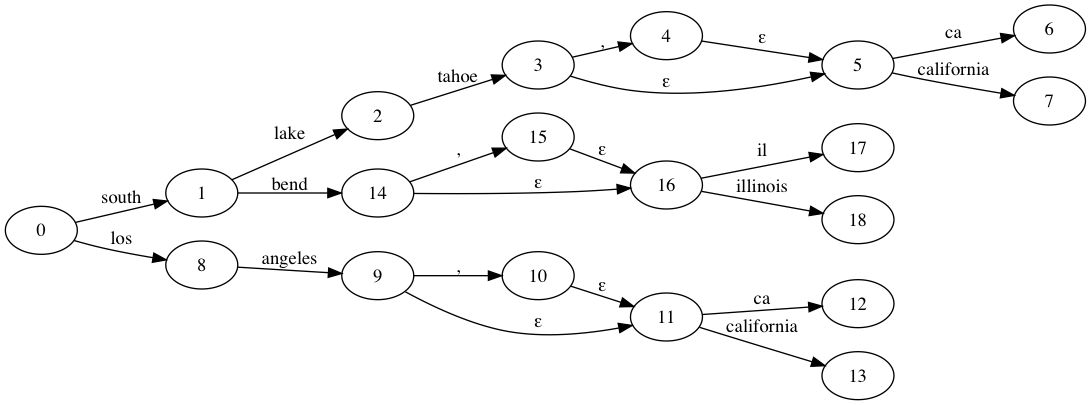

In [520]:
plot(g)

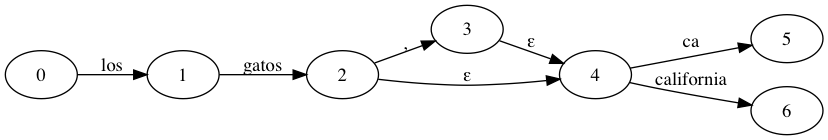

In [484]:
plot(g2)

In [485]:
def edge_match(e1, e2):
    return e1.get('accept_fn') == e2.get('accept_fn')

In [504]:
sg3 = nx.subgraph(g, nx.descendants(g, 3) | {3})
sg9 = nx.subgraph(g, nx.descendants(g, 9) | {9})

In [507]:
hash(sg9)

277360511

In [514]:
plot(nx.topological_sort(g))

AttributeError: 'generator' object has no attribute 'is_directed'